# Normal distribution
In this file, I create and simulate a normally distributed random variable. In the second part, I create a multivariate_normal variable and simulate it. Lastly, I perform a bootstrap simulation.

In [1]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as datetime
import numpy as np
import scipy.stats as stats
import statsmodels as sm

In [2]:
def adjust(stock,delta=8):
    """
    A function that retrieves the closing prices of a stock within a specified time period.

    Parameters:
        stock (str): The name or ticker symbol of the stock.
        delta (int): The number of days to go back from today. Default is 8.

    Returns:
        pandas.DataFrame: A DataFrame containing the closing prices of the stock.
    """

    stock=pd.DataFrame(yf.download(stock,start=datetime.date.today()-datetime.timedelta(days=delta))).reset_index() # creat_df
    return(stock['Close'])
adjust('aapl',delta=1500).head()


[*********************100%***********************]  1 of 1 completed


0    52.167500
1    51.755001
2    51.935001
3    52.419998
4    52.195000
Name: Close, dtype: float64

MLE for $\mu$:
$\pi\frac{1}{\sqrt{2\pi\sigma^{2}}}*e^{-\frac{1}{2}*(\frac{x-\mu}{\sigma})^{2}}


\\\\(\frac{1}{\sqrt{2\pi\sigma^{2}}})^{n}*e^{-\frac{1}{2}*(\frac{\sum_{i=1}^{i=n}x-n\mu}{\sigma})}ln(c)+-\frac{1}{2}*(\frac{\sum_{i=1}^{i=n}x-n\mu}{\sigma})^{2}


\\\\\nabla\mu:\frac{2(\sum_{i=1}^{i=n}x-nu)}{\sigma^{2}}=0

\\\\\mu=\bar{x}

\\\\\nabla_{2}\mu:-2n<0 $

MLE for $\sigma^2$:

$\pi\frac{1}{\sqrt{2\pi\sigma^{2}}}*e^{-\frac{1}{2}*(\frac{x-\mu}{\sigma})^{2}}

\\ (\frac{1}{\sqrt{2\pi\sigma^{2}}})^{n}*e^{-\frac{1}{2}*(\frac{\sum_{i=1}^{i=n}x-n\mu}{\sigma})}

n\\ln(\frac{1}{\sqrt{2\pi\sigma^{2}}})-\frac{1}{2}*(\frac{\sum_{i=1}^{i=n}x-n\mu}{\sigma})^{2}

\\ ln(c)-\frac{n}{2}ln(\sigma^{2})-\frac{1}{2}(\frac{\sum_{i=1}^{i=n}x-n\mu}{\sigma})^{2}

\\ln(c)-\frac{n}{2}ln(\sigma^{2})-\frac{1}{2}\frac{(\sum_{i=1}^{i=n}x-n\mu)^{2}}{\sigma^{2}}

\\\nabla_{\sigma^{2}}-\frac{n}{2\sigma^{2}}+\frac{(\sum_{i=1}^{i=n}x-n\mu)^{2}}{2\sigma^{4}}=0

\\ n \sigma^{2}=(\sum_{i=1}^{i=n}x-n\mu)^{2}
\\\sigma^{2}=\frac{(\sum_{i=1}^{i=n}(x-\mu))^{2}}{n}$


In [3]:
"This function describes mu and sigma of variable, here I consider the distribution of the return in the stock market as normal"
def normal_Dist(stock,delta=1500):
    """
    This function calculates the mean (mu) and standard deviation (sigma) of a variable, assuming a normal distribution.
    Here, the variable represents the returns in the stock market.

    Parameters:
        stock (str): The name or ticker symbol of the stock.
        delta (int): The number of days to go back from today. Default is 1500.

    Returns:
        list: A list containing the mean (mu) and standard deviation (sigma) of the variable.
    """

    stock=adjust(stock,delta=delta).pct_change()[1:] # "Retrieve the data and convert the prices to percentages."
    mu=round(stock.mean()*100,3) #
    sigma=round(stock.var()**0.5*100,3)
    return([mu,sigma])
normal_Dist('aapl')


[*********************100%***********************]  1 of 1 completed


[0.146, 2.117]

In [4]:
'Check the assumption that the stock has a normal distribution.'
true_data=adjust('aapl',delta=300).pct_change()[1:]
det=normal_Dist('aapl')
chay_sq = lambda x, y: ((y-x )**2)/x  # compute chay_sq
result=sum([chay_sq(x=det[0],y=i) for i in true_data])
 #1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
print(f"chi square={round(stats.chi2.cdf(result,len(true_data)),4)} The chi-square value is small, so we can't conclude that the stock return is not normally distributed.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
chi square=0.0 The chi-square value is small, so we can't conclude that the stock return is not normally distributed.


In [5]:
def matrix_d():
    """
    Creates a matrix of stocks with their variances (var) and means (mu) in a normal distribution.

    Returns:
        pandas.DataFrame: A DataFrame containing the stocks' names, means (mu), and variances (sigma).
    """
    names_of_stocks = ['MSFT', 'AAPL', 'NVDA', 'AMZN']
    normal_dict={'Name':[],'Mu':[],'Sigma':[]}
    for i in names_of_stocks:
        normal_dict['Name'].append(i)
        res=normal_Dist(stock=i,delta=1500)
        normal_dict['Mu'].append(res[0])
        normal_dict['Sigma'].append(res[1])

    normal_dict=pd.DataFrame(data=normal_dict)
    return (normal_dict.sort_values(by='Mu',ascending=False).reset_index(drop=True))

matrix_d()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Name,Mu,Sigma
0,NVDA,0.290,3.405
1,AAPL,0.146,2.117
2,MSFT,0.102,2.031
3,AMZN,0.058,2.314


[*********************100%***********************]  1 of 1 completed


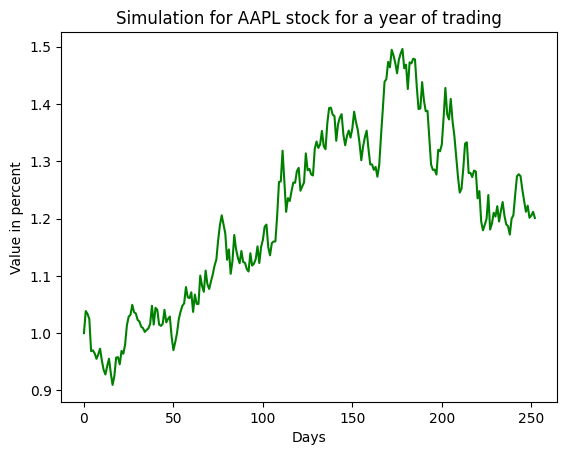

In [6]:
'Function that makes simulation for one year of trading.'
def simualtion(stock):
    """

    Performs a simulation of one year of trading for a given stock.

    Parameters:
        stock (str): The stock name or symbol.

    Returns:
        None ;
    Plots:
        A graph showing the simulated value of the stock over the course of one year of trading.
    """
    name=stock
    stock=normal_Dist(stock)
    np.random.seed(11) # set seed
    random_r=np.random.normal(stock[0]/100,stock[1]/100,252)
    l=[1]
    for i in random_r: # adjust the change for each day
        l.append(l[-1]*(1+i))
    plt.plot(l,color='green') if l[-1]>1 else plt.plot(l,color='red')
    plt.xlabel('Days')
    plt.ylabel('Value in percent')
    plt.title(f"Simulation for {name} stock for a year of trading")
simualtion('AAPL')



[*********************100%***********************]  1 of 1 completed


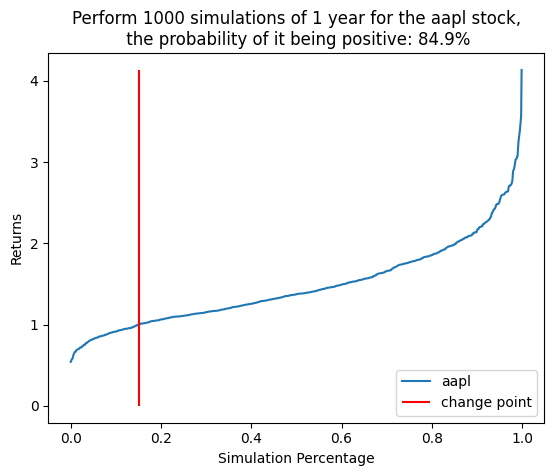

In [7]:
def simualtion_1000(stock):
    """
    Performs 1000 simulations of one year of trading for a given stock, plots the distribution of stock values at the end of the year,
    and prints the probability of the stock being positive.

    Parameters:
        stock (str): The stock name or symbol.

    Returns:
        None

    Plots:
        - A distribution plot showing the value of the stock at the end of the year for each simulation.

    """
    name=stock
    np.random.seed(11)
    stock=normal_Dist(stock)
    x=[]
    for j in range(1000):
        l=[1]
        random_r=np.random.normal(stock[0]/100,stock[1]/100,252)

        for i in random_r:
            l.append(l[-1]*(1+i))
        x.append(l[-1])
    plt.plot(np.arange(0,1,0.001),sorted(x),label=name)


    l=[1 for i in x if i<1]
    prob_positive=(len(l)/1000)
    'Adjsut the plot'
    plt.vlines(len(l)/1000,0,max(x),color='red',label='change point')
    plt.title(f'Perform 1000 simulations of 1 year for the {name} stock,\n the probability of it being positive: {round((1-prob_positive)*100,3)}%')
    plt.legend(loc='lower right')
    plt.xlabel('Simulation Percentage')
    plt.ylabel('Returns')



simualtion_1000('aapl')

In [8]:

def mean_dist_of_sim(stock):
    """
    Computes the mean return and variance of a stock over a period of 1 year using simulation.

    Parameters:
        stock (str): The stock name or symbol.

    Returns:
        list: A list containing the mean return and variance of the stock.

    Simulation:
        - Performs 1000 simulations of one year of trading for the given stock.
        - Computes the final value of the stock for each simulation.
        - Calculates the mean return and variance of the stock values.
    """
    stock=normal_Dist(stock)
    x=[]
    v_l=[]
    for j in range(1000):
        l=[1]
        random_r=np.random.normal(stock[0]/100,stock[1]/100,252)
        for i in random_r:
            l.append(l[-1]*(1+i))

        x.append(l[-1])
    mu=np.mean(x)
    sigma=np.var(x)**0.5

    return ([mu,round(sigma,3)])
mean_dist_of_sim('aapl')




[*********************100%***********************]  1 of 1 completed


[1.4370551506370406, 0.504]

second part : In this part I will work with the multynorm distrbution and I will check appropriate

In [9]:
def create_matrix():
    """
    Creates a DataFrame of stocks with their closing prices.

    Returns:
        pandas.DataFrame: A DataFrame containing the closing prices of the stocks.
    """

    d=pd.DataFrame()
    list_of_stock=['aapl','msft','nvda','dell']
    for i in list_of_stock:
        d[i]=pd.DataFrame(adjust(i,delta=1500)).pct_change()[1:]
    return d

d=create_matrix()
'Split the data for train and test'
data_train=d.iloc[:int(len(d)*0.8)]
data_test=d.iloc[int(len(d)*0.8):]
mean_train=data_train.mean()  # vector of the mean
cov_train=data_train.cov() # cov matrix


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


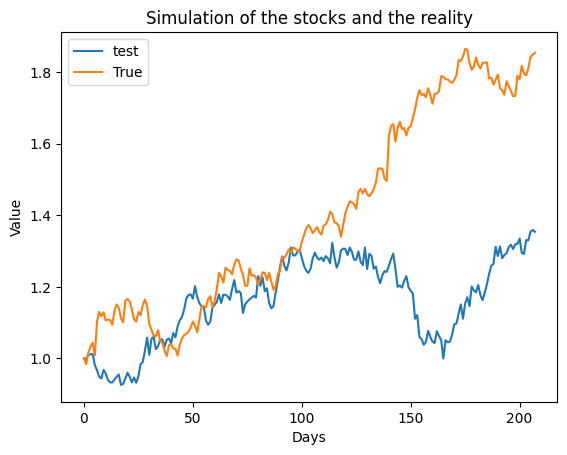

In [10]:
"A function that creates a simulation of the bug using a multivariate_normal distribution."
def simualtion_bug(means,covs,d_test):
    """
    Creates a simulation of a bug using a multivariate_normal distribution.

    Parameters:
        means (array-like): Mean values for the multivariate normal distribution.
        covs (array-like): Covariance matrix for the multivariate normal distribution.
        d_test (pandas.DataFrame): Test data for the simulation.

    Returns:
        None

    Simulation:
        - Generates random samples from the multivariate normal distribution defined by means and covs.

    Plots:
        - A line plot showing the simulated cumulative returns (labeled 'test') and the true cumulative returns (labeled 'True').
    """
    np.random.seed(19)
    random_r=np.random.multivariate_normal(means, covs,len(d_test))
    random_r=(random_r*0.25)
    x=[round(sum(i),3) for i in random_r]

    l_2=[1]
    y=[sum(d_test.iloc[i])/4 for i in range(len(d_test))]
    l=[1]

    for i in x:
        l.append(round(l[-1]*(1+i),3))

    for i in y:
        l_2.append(round(l_2[-1]*(1+i),3))

    plt.plot(l,label='test')
    plt.plot(l_2,label='True')
    plt.title('Simulation of the stocks and the reality')
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Value')



simualtion_bug(mean_train,cov_train,data_test.reset_index(drop=True))


Part 2
"In this part, I will attempt to predict the price of the stock using the bootstrap method."

[*********************100%***********************]  1 of 1 completed


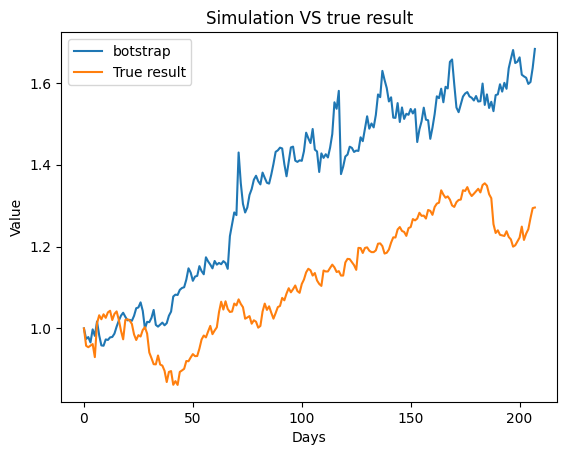

In [11]:
'''
The bootstrap_sim function takes the name of a stock, utilizes the bootstrap method to make predictions,
and assesses its accuracy against the ground truth.
To evaluate the results against the truth, we split the data into training and testing sets.
'''

def bootstrap_sim(stock):
    """
    Performs bootstrap simulation for a given stock and assesses its accuracy against the ground truth.

    Parameters:
        stock (str): The stock name or symbol.

    Returns:
        None

    Bootstrap Simulation:
        - Retrieves the stock data using the `adjust` function with a delta of 1500.
        - Splits the data into training and testing sets.
    Plots:
        - A line plot showing the simulated cumulative returns (labeled 'bootstrap') and the true cumulative returns (labeled 'True result').

    """
    np.random.seed(8)  # seet seed

    stock=adjust('aapl',delta=1500).pct_change()[1:]
    'Split the data for train and test'
    train=stock[:int(len(stock)*0.8)].to_list()
    test=stock[int(len(stock)*0.8):].to_list()
    result = np.random.choice(train, size=len(test), replace=True)  # Sampling from the 'train' dataset

    l=[1]
    'calculate the series change for simulation'
    for i in range(len(result)):
        l.append(l[-1]*(1+result[i]))
    result=l
    l=[1]
    'calculate the series change for result'
    for i in range(len(test)):
        l.append(l[-1]*(1+test[i]))

    test=l
    plt.plot(result,label='botstrap')
    plt.plot(test,label='True result')
    plt.title('Simulation VS true result')
    plt.ylabel('Value')
    plt.xlabel('Days')
    plt.legend()


bootstrap_sim('AAPL')






Dash and plotly part

In [12]:
from dash import Dash, dcc, html, Input, Output,State
import plotly.express as px

'''
The seq_f function takes stock data and returns the length and identifies the last sequence of that stock.
'''
def seq_f(list_stock):
    """
    Takes a list of stock price and identifies the length and nature of the last sequence
    (either positive, negative, or neutral days).

    Parameters:
        list_stock (list): A list of stock values.

    Returns:
        str: A string description of the last sequence, e.g., '3 negative days'.
    """

    c=1
    if list_stock[-1]<list_stock[-2]:
        for i in range(2,len(list_stock)):
            if list_stock[-i]<list_stock[-i-1]:
                c+=1
            else:
                break
        seq=f'{c} negative days'
    if list_stock[-1]>list_stock[-2]:
        for i in range(2,len(list_stock)):
            if list_stock[-i]>list_stock[-i-1]:
                c+=1
            else:
                break
        seq=f'{c} positive days'
    if list_stock[-1]==list_stock[-2]:
        seq='=='
    return (seq)
a=adjust('msft',900)

seq_f(a.to_list())

[*********************100%***********************]  1 of 1 completed


'1 negative days'

## NEW dash

In [14]:
'''
Create a dashboard using Dash and Plotly. In the dashboard, provide the user with the option to select a stock and visualize it in the graph.
'''
import dash
from dash import dcc, html,dash_table
from dash.dependencies import Input, Output
import plotly.express as px
import numpy as np
import plotly.graph_objects as go

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Stock information'),
    html.H2('Graph '),
    dcc.Graph(id="time-series-chart"),

    html.P("Choose a stock and then press Enter:"),
    dcc.Input(
        id="ticker",
        type='text',
        debounce=True,
        value='MSFT'
    ),

    html.P("Choose Number of days:"),
    dcc.Input(
        id="N_days",
        type='number',
        debounce=True,
        value=1350  # Default value if needed
    ),

html.Div([  # This is the main row

    # First column for the BOOT STRAP simulation graph
    html.Div([
        html.H2('Bootstrap simulation'),
        dcc.Graph(id="new-graph", style={'height': '400px', 'width': '800px'})
    ], style={'width': '33%', 'display': 'inline-block', 'verticalAlign': 'top'}),  # Adjust width and added verticalAlign

    # Second column for the Normal simulation graph
    html.Div([
        html.H2('Normal distribution simulation'),
        dcc.Graph(id="norm-graph", style={'height': '400px', 'width': '800px'})
    ], style={'width': '33%', 'display': 'inline-block', 'marginRight': '-2%', 'verticalAlign': 'top'}),  # Adjusted margin and added verticalAlign

    # Third column for the table
    html.Div([
        html.H2('Data summary'),
        dash_table.DataTable(
            id='per-T',
            columns=[{'name': 'category', 'id': 'category'}, {'name': 'value', 'id': 'value'}],
            style_cell={
                'textAlign': 'left',
                'fontSize': '25px'
            },
            style_data={
                'color': 'black',
                'backgroundColor': 'white'
            },
            style_data_conditional=[
                {
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'lightblue',
                }
            ],
            style_header={
                'backgroundColor': 'lightblue',
                'color': 'black',
                'fontWeight': 'bold',
                'fontSize': '25px'
            }
        )
    ], style={'width': '13%', 'display': 'inline-block', 'verticalAlign': 'top'})  # added verticalAlign
])
])
@app.callback(
    Output("time-series-chart", "figure"),
     [Input("ticker", "value"),
     Input("N_days", "value")]
)
def main_plot(ticker,N_days):
    stock = adjust(ticker, delta=int(N_days))  # Use N_days in delta
    per_change = 1 + ((stock - stock.iloc[0]) / stock.iloc[0])

    fig = px.line(per_change)
    fig.update_traces(name=f'{ticker} Stock price')
    fig.update_layout(xaxis_title="N", yaxis_title='value', title=f'This is the change in {ticker} for the last {N_days} days')
    fig.update_traces(line=dict(color="green")) if per_change.tolist()[-1]>1 else fig.update_traces(line=dict(color="red"))


    return fig


@app.callback(
    Output("new-graph", "figure"),
      [Input("ticker", "value"),
     Input("N_days", "value")])
def new_g(ticker,N_days):
    np.random.seed(8)  # seet seed

    stock=adjust(ticker,delta=N_days).pct_change()[1:]
    'Split the data for train and test'
    train=stock[:int(len(stock)*0.8)].to_list()
    test=stock[int(len(stock)*0.8):].to_list()
    result = np.random.choice(train, size=len(test), replace=True)  # Sampling from the 'train' dataset

    l=[1]
    'calculate the series change for simulation'
    for i in range(len(result)):
        l.append(l[-1]*(1+result[i]))
    result=l
    l=[1]
    'calculate the series change for result'
    for i in range(len(test)):
        l.append(l[-1]*(1+test[i]))

    test=l

    fig = go.Figure()

    fig.add_trace(go.Scatter(y=result, mode='lines', name='Simulated Data'))
    fig.add_trace(go.Scatter(y=test, mode='lines', name='Actual Data'))
    fig.update_layout(xaxis_title="N", yaxis_title='value',title="Bootstrap Simulation Results")  # Add this line


    'part 3 add normal simlation'
    return fig
@app.callback(
    Output("norm-graph", "figure"),
      [Input("ticker", "value"),
     Input("N_days", "value")])

def n_g(ticker,N_days):
    name=ticker
    stock=adjust(name,delta=N_days) # "Retrieve the data and convert the prices to percentages."
    train=stock.iloc[:int(len(stock)*0.8)].pct_change()[1:]
    test=stock.iloc[int(len(stock)*0.8):].reset_index(drop=True)
    test=1+((test-test.iloc[0])/test.iloc[0])
    mu=round(train.mean()*100,3) #
    sigma=round(train.var()**0.5*100,3)
    np.random.seed(11) # set seed
    random_r=np.random.normal(mu/100,sigma/100,len(test)-1)
    l=[1]
    for i in random_r: # adjust the change for each day
        l.append(l[-1]*(1+i))
    #fig=px.line(l)

    fig = go.Figure()

    fig.add_trace(go.Scatter(y=l, mode='lines', name='Simulated Data'))
    fig.add_trace(go.Scatter(y=test, mode='lines', name='Actual Data'))
    fig.update_layout(xaxis_title="N", yaxis_title='value',title="Normal distribution Simulation Results")  # Add this line

    return fig

@app.callback(
    Output("per-T", "data"),
      [Input("ticker", "value"),
     Input("N_days", "value")])
def table(ticker,N_days):
    stock=adjust(ticker,delta=N_days)# "Retrieve the data and convert the prices to percentages."
    mean=stock.mean().round(2)
    sd=round(stock.var()**0.5,3)
    list_stock=stock.to_list()
    seq=seq_f(list_stock)
    df = pd.DataFrame({'category': ['mean', 'sd','seq'], 'value': [mean, sd,seq]})
    return df.to_dict('records')




if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [01/Sep/2023 10:02:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 10:02:09] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 10:02:09] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 10:02:09] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Sep/2023 10:02:09] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Sep/2023 10:02:09] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Sep/2023 10:02:09] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -


[*********************100%***********************]  1 of 1 completed




127.0.0.1 - - [01/Sep/2023 10:02:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 10:02:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2023 10:02:10] "POST /_dash-update-component HTTP/1.1" 200 -


127.0.0.1 - - [01/Sep/2023 10:02:10] "POST /_dash-update-component HTTP/1.1" 200 -
